# The Correlative Relationship Between Average Total Area Burned  by Wildfire and Wind Speed

## Introduction

Wildfires are a dangerous and incredibly destructive phenomenon of nature, which makes understanding and predicting them perimount to curbing their destructive potential in the future. However, there are innumerable factors to consider when trying to predict the effects of a wildfire. Of the two “most important” factors in how wildfires are spread, wind speed is “the most variable and the least predictable.” However, in spite of its variability, its predictive power is immense. So much so that there exists a simple “10% rule” that approximates a wildfire's rate of spread simply through “10% of the average 10-m open wind speed.” This simple model can produce results “comparable to those obtained by the established fire spread rate models” while only accounting for the wind speed factor.

For our project we aim to put the literature to the test and see just how powerful a factor wind speed truly is for ourselves. We aim to answer the question “What is the difference in average total area burned by a wildfire between times of low wind speed and times of high wind speed?” We would also like to approximate the standard deviation of this difference to see if the results are consistently statistically significant. To answer our question, we have made use of a dataset containing data of the total area burned from 517 forest fires in the northeastern region of Portugal. This dataset also includes the wind speed among other less relevant variables.

## Preliminary Results

In [15]:
# Load the necessary packages.
library(GGally)
library(tidyverse)
library(infer)
library(cowplot)
library(broom)

In [16]:
#Setting the seed.
set.seed(1234)

#Dowloading the data from the web and reading it in R.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"

filepath <- "../data/forestfires.csv"

# download the file if its not present
if (!file.exists(filepath)) {
    download.file(url, filepath)
}

# select the columns we need, and filter out NA values
forest_fires_data <-read_delim(filepath, skip=0, delim=",") %>%
    select(wind, area) %>%
    mutate(wind = as.numeric(wind), area = as.numeric(area)) %>% #Wrangling data and selecting columns to be used in prediction
    filter(!is.na(wind) | !is.na(area))
    
head(forest_fires_data)

Rows: 517 Columns: 13
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


wind,area
<dbl>,<dbl>
6.7,0
0.9,0
1.3,0
4.0,0
1.8,0
5.4,0


### Wind Speed Distributions

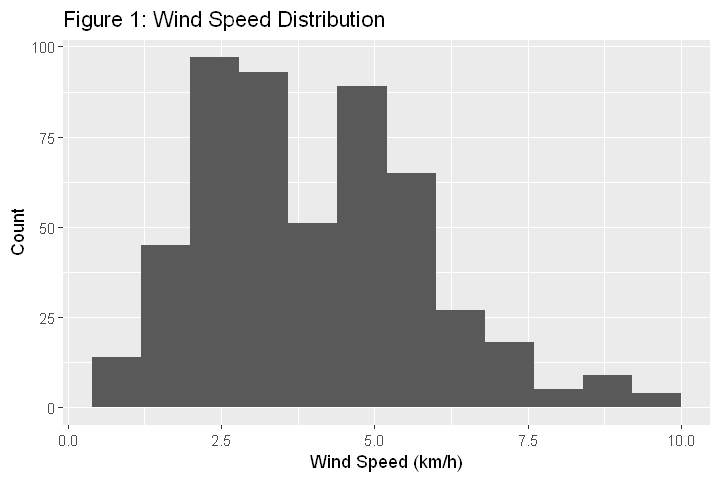

In [17]:
options(repr.plot.width = 6, repr.plot.height = 4)

## Plotting out the distribution of the wind speeds from the data
wind_speed_plot <- forest_fires_data %>%
    ggplot(aes(x = wind))+
    geom_histogram(binwidth = 0.8) + 
    labs(x="Wind Speed (km/h)", y="Count")+
    ggtitle("Figure 1: Wind Speed Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 11)) 

wind_speed_plot

In Figure 1 we can see that the distribution follows a bimodal distribution. This allows us to use the two peaks as reference as to whether or not any particular windspeed should be classified as either "high" speed or "low" speed.

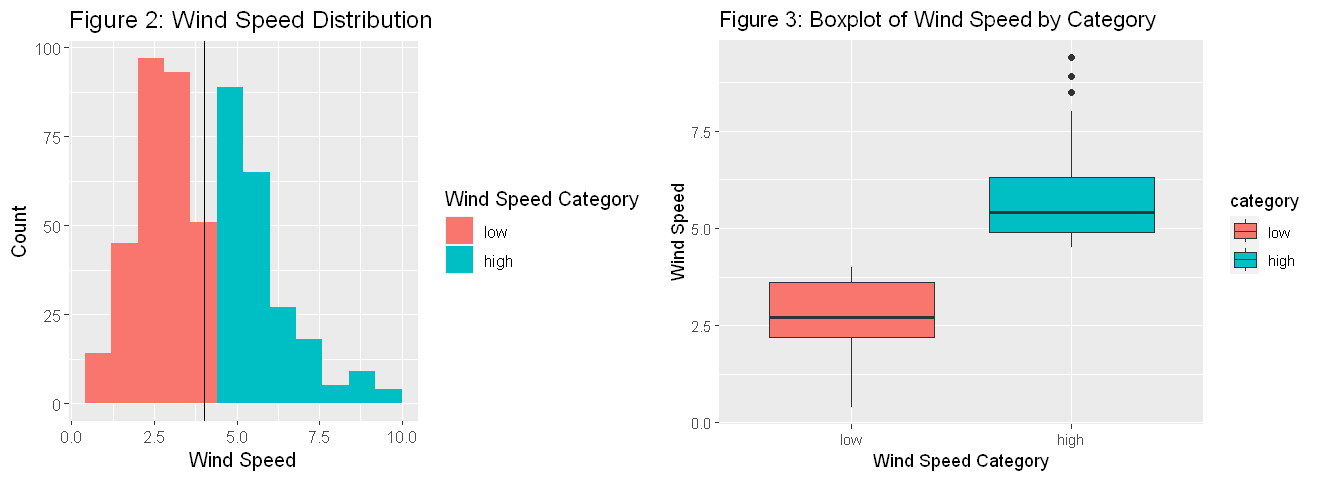

In [18]:
xs <- quantile(forest_fires_data$wind,c(0,1/2,1))

## adding the category column
forest_fires_data <- forest_fires_data %>%
    mutate(category=cut(wind, breaks=xs, labels=c("low","high"),include.lowest = TRUE))

## visualizing the split between "high" and "low" windspeed
wind_plot_categorized <- forest_fires_data %>%
    ggplot(aes(x = wind, fill = category))+
    geom_histogram(binwidth = 0.8) + 
    labs(x = "Wind Speed", y="Count")+
    ggtitle("Figure 2: Wind Speed Distribution") +
    scale_fill_discrete(name = "Wind Speed Category") +
    theme(text = element_text(size = 12)) + 
    geom_vline(aes(xintercept = quantile(wind)[3]))

## creating boxplot for "high" and "low" windspeeds distributions
box_plot <- forest_fires_data %>%
  ggplot(aes(x = category, y = wind, fill = category)) +
  geom_boxplot() +
  labs(x="Wind Speed Category", y="Wind Speed") +
  ggtitle("Figure 3: Boxplot of Wind Speed by Category") 

options(repr.plot.width = 11, repr.plot.height = 4)
plot_grid(wind_plot_categorized, box_plot)

Figure 2 simply visualizes how the high-low split looks like. Figure 3 is reiterating the same information but with a box plot instead. Due to the manner by which we deriaved the high and low catagories, there's no overlap between the two of them.

### Area Burned Distributions

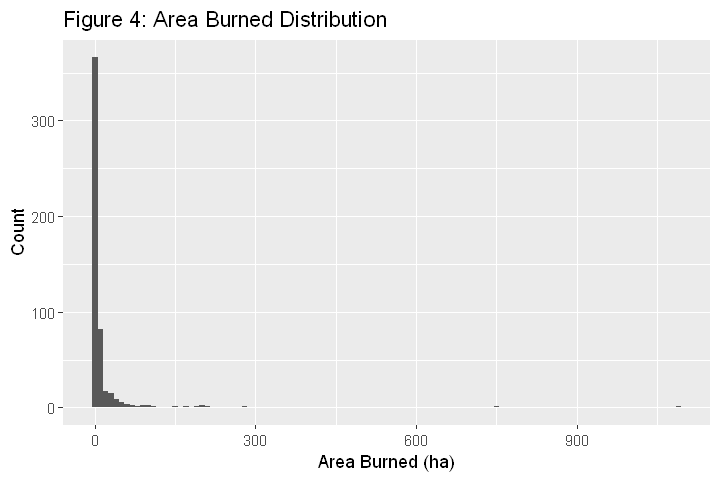

In [19]:
options(repr.plot.width = 6, repr.plot.height = 4)

## Plotting the distribution of area burned from data
area_burned_plot <- forest_fires_data %>%
    ggplot(aes(x = area))+
    geom_histogram(binwidth = 10) + 
    labs(x = "Area Burned (ha)", y = "Count")+
    ggtitle("Figure 4: Area Burned Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 11))
area_burned_plot   

Figure 4 shows a massive right skew in the data. This structure means that it would make sense to scale the data using a logrithmic scale.
> See https://www.programmingr.com/tutorial/log-in-r/.

In [20]:
## Adding log scale column 
forest_fires_data <- forest_fires_data %>%
    mutate(area_log10 = log10(1+ area))

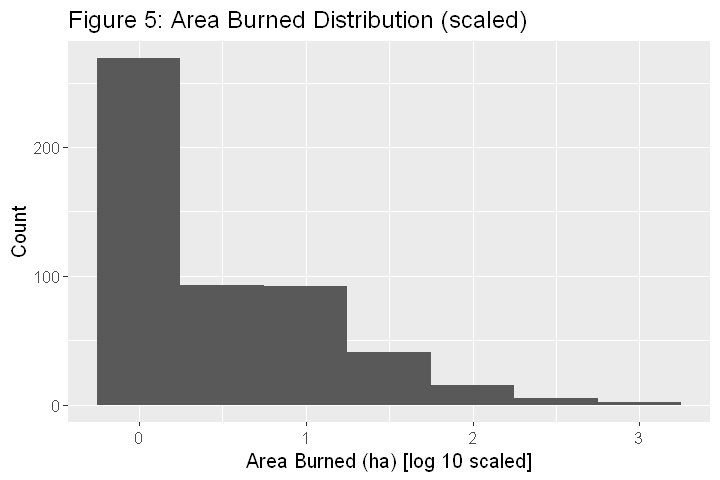

In [21]:
options(repr.plot.width = 6, repr.plot.height = 4)

## Plotting area burned distribution with the newly scaled data
area_burned_scaled_plot <- forest_fires_data %>%
    ggplot(aes(x =area_log10))+
    geom_histogram(binwidth = 0.5) + 
    labs(x="Area Burned (ha) [log 10 scaled]", y="Count")+
    ggtitle("Figure 5: Area Burned Distribution (scaled)") +
    scale_fill_discrete(name = "Month of Fires") +
    theme(text = element_text(size = 12))

## Plotting boxplot of area burned with respect to which wind speed catagory the observation belongs to
box_plot_burned <- forest_fires_data %>%
  ggplot(aes(x = category, y = area_log10, fill = category)) +
  geom_boxplot() +
  labs(x="Scaled Area vs Wind Speed Category", y="Scaled Area Burned (ha)")+
  ggtitle("Figure 6: Boxplot of Area Burned by Category")

area_burned_scaled_plot

Figure 5 is the newly scaled distribution for the area burned. We can see that it still follows a similar shape as before, but it's a bit easier to see what's actually going on. 

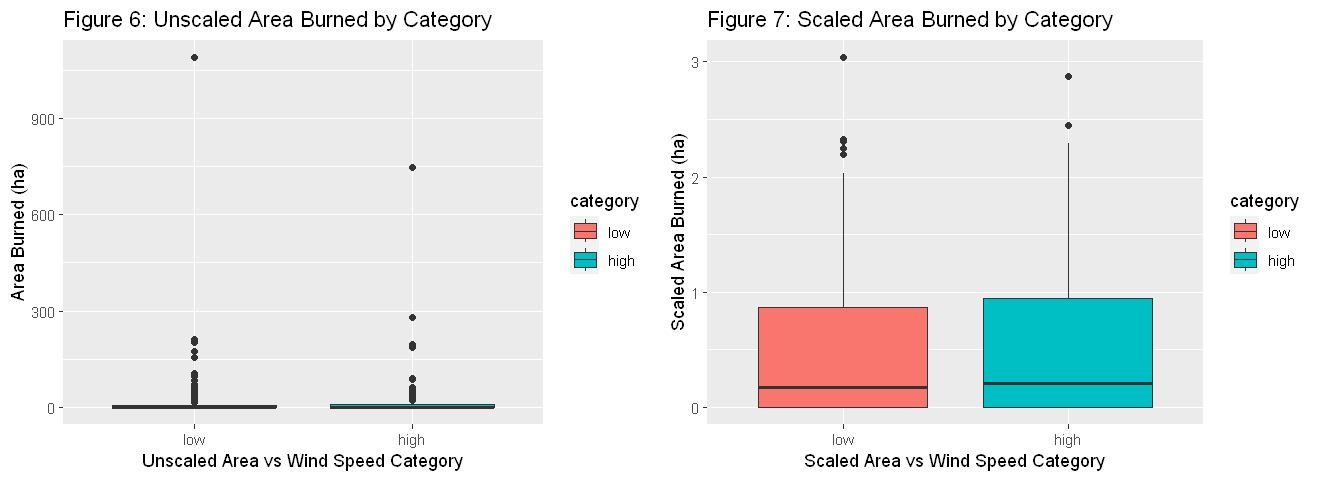

In [22]:
## Plotting boxplot of area burned with respect to which wind speed catagory the observation belongs to
box_plot_burned_unscaled <- forest_fires_data %>%
  ggplot(aes(x = category, y = area, fill = category)) +
  geom_boxplot() +
  labs(x = "Unscaled Area vs Wind Speed Category", y = "Area Burned (ha)")+
  ggtitle("Figure 6: Unscaled Area Burned by Category")

## Plotting boxplot of area burned [scaled] with respect to which wind speed catagory the observation belongs to
box_plot_burned_scaled <- forest_fires_data %>%
  ggplot(aes(x = category, y = area_log10, fill = category)) +
  geom_boxplot() +
  labs(x = "Scaled Area vs Wind Speed Category", y = "Scaled Area Burned (ha)")+
  ggtitle("Figure 7: Scaled Area Burned by Category")


options(repr.plot.width = 11, repr.plot.height = 4)
plot_grid(box_plot_burned_unscaled, box_plot_burned_scaled)

Figure 6 and 7 show the unscaled and scaled area burned distributions under both wind catagories. We can see here that the two catagories actually have very similar distributions, with a slighly higher variance in "high" wind speed catagory compared to the "low" wind speed catagory.

In [23]:
## Creating summary statistic for "low" wind speed catagory
forest_fires_data %>%
group_by(category) %>%
filter(category == "low") %>%
summary()

## Creating summary statistic for "high" wind speed catagory
forest_fires_data %>%
group_by(category) %>%
filter(category == "high") %>%
summary()

      wind            area          category     area_log10    
 Min.   :0.400   Min.   :   0.000   low :300   Min.   :0.0000  
 1st Qu.:2.200   1st Qu.:   0.000   high:  0   1st Qu.:0.0000  
 Median :2.700   Median :   0.495              Median :0.1746  
 Mean   :2.779   Mean   :  12.615              Mean   :0.4699  
 3rd Qu.:3.600   3rd Qu.:   6.365              3rd Qu.:0.8672  
 Max.   :4.000   Max.   :1090.840              Max.   :3.0382  

      wind            area        category     area_log10    
 Min.   :4.500   Min.   :  0.00   low :  0   Min.   :0.0000  
 1st Qu.:4.900   1st Qu.:  0.00   high:217   1st Qu.:0.0000  
 Median :5.400   Median :  0.61              Median :0.2068  
 Mean   :5.729   Mean   : 13.17              Mean   :0.5000  
 3rd Qu.:6.300   3rd Qu.:  7.73              3rd Qu.:0.9410  
 Max.   :9.400   Max.   :746.28              Max.   :2.8735  

Most of these stats for the wind are what you would expect to see given how we split that data to create the catagories. The area of interest here is how the catgory differences are reflected in the area and area_log 10 columns. We can see here that most of the statistic are pretty similar, with even the MAX on the "low" catagory having a significantly higher MAX than the "high" catagory (which is pretty suprising), but that the "high" catagory still has a higher MEAN (though the difference is pretty small).

## Methods and Results

In [24]:
order <- c("low", "high")

dataset <- read_csv('../data/forestfires.csv') %>%
  select(wind, area) %>%
  mutate(wind = as.numeric(wind), area = as.numeric(area)) %>% #Wrangling data and selecting columns to be used in prediction
  filter(!is.na(wind) | !is.na(area)) %>%
  mutate(
    category=cut(wind, breaks = quantile(wind,c(0,1/2,1)), labels = order,include.lowest = TRUE),
    area_log10 = log10(1+ area)
  )

Rows: 517 Columns: 13
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Confidence Interval

In [25]:
# calculate our sample statistic (average diff in means)
obs_diff_means <- dataset %>% 
  specify(formula = area_log10 ~ category) %>% 
  calculate(stat = "diff in means", order = order)

obs_diff_means

stat
<dbl>
-0.03014077


# A tibble: 1 x 2
  lower_ci upper_ci
     <dbl>    <dbl>
1   -0.143   0.0766


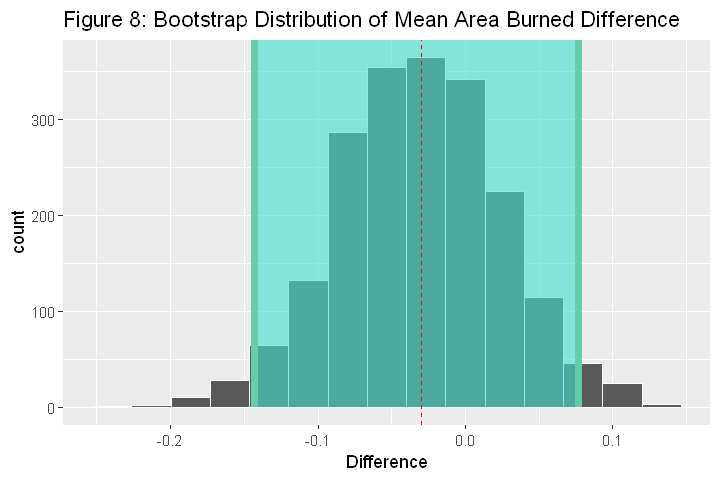

In [26]:
options(repr.plot.width = 6, repr.plot.height = 4)

# set the seed so that the randomization is consistent
set.seed(1234)

# bootstrap with 2000 replicate
bootstrap_dist_data_infer <- dataset %>%
    specify(formula = area_log10 ~ category) %>%
    generate(type = "bootstrap", reps = 2000) %>%
    calculate(stat = "diff in means", order = order) 

# get the upper and lower bound of the confidence interval generated by the bootstrap distribution
percentile_ci <- bootstrap_dist_data_infer	%>%
    get_ci(type = "percentile", level = 0.95)
print(percentile_ci)

# confidence interval of the difference in mean area burned
bootstrap_dist_data_infer %>%
    visualize() +
    shade_confidence_interval(endpoints = percentile_ci) +
    geom_vline(xintercept = obs_diff_means$stat, linetype = "dashed", color = "red") +
    labs(
        title = 'Figure 8: Bootstrap Distribution of Mean Area Burned Difference',
        x = 'Difference'
    )

Above is the visualization of our confidence interval. Our interval at a 95% confidence level is between -0.143 and 0.0766. This means that we are 95% confident that the true difference between the scaled area burned between the two wind speed catagories is between -0.143 and 0.0766 log10 Ha (log10 Hectare).

### Simulation Based Hypothesis Test

Warning message:
"Parameter values are not specified when testing that two variables are independent."


p_value
<dbl>
0.578


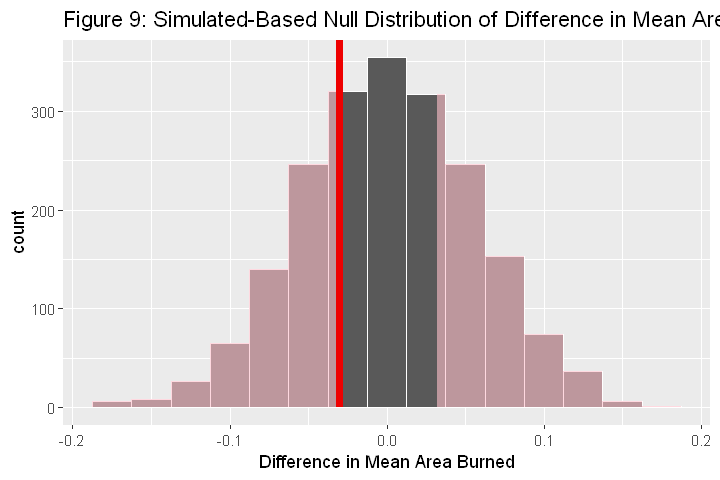

In [27]:
alpha <- 0.05

# null distribution (N0 : mu1 - mu1 = 0) of the difference in means
# since we are not generating a bootstrap distribution, type is set to "permute"
null_distribution_mean <- dataset %>%
  specify(formula = area_log10 ~ category) %>% 
  hypothesize(null = "independence", mu = 0) %>% 
  generate(reps = 2000, type = "permute") %>% 
  calculate(stat = "diff in means", order = order)

# visualize into histogram and show where the p-value lies
null_distribution_mean %>%
    visualize() +
    shade_p_value(obs_stat = obs_diff_means, direction = "two_sided") +
    labs(title = 'Figure 9: Simulated-Based Null Distribution of Difference in Mean Area Burned', x = 'Difference in Mean Area Burned')

# calculate precise p-value of our statistic under the null model
null_distribution_mean %>% 
  get_p_value(obs_stat = obs_diff_means, direction = "both")

Our p value from the simulation based approach is 0.578. This means that under our null model (where both windspeed catagories are assumed to have equal areas burned) there is a probabilty of 0.578 to produce a sample with a statistic that is either equal or more extreme than our observed statistic (-0.0301).

### Theory Based Hypothesis Test

In [28]:
# split the category
high_cat <- filter(dataset, category == 'high')
low_cat <- filter(dataset, category == 'low')

# find the variance across both categories
var1 <- var(high_cat$area_log10)
var2 <- var(low_cat$area_log10)

# count the rows
n1 <- high_cat %>% nrow()
n2 <- low_cat %>% nrow()

# calculate degrees of freedom for populations with unequal variances
var1n1 <- (var1/n1)
var2n2 <- (var2/n2)
df <- (var1n1/var2n2)^2 / ((1/(n1-1))*var1n1^2 + (1/(n2-1))*var2n2^2)

# calculate the t-statistic
t_stat <- (obs_diff_means) / sqrt((var1/n1) + (var2/n2))

# comparing t stat to t distribution under null model and finding the p-value (multiply by 2 for two-tailed test)
p_value <- pt(t_stat$stat, df)*2

print(p_value)

[1] 0.5799658


Our p value from the theory based approach is 0.579. This means that under our null model (where both windspeed catagories are assumed to have equal areas burned) there is a probabilty of 0.579 to produce a sample with a statistic that is either equal or more extreme than our observed statistic (-0.0301).

### Comparison

Before we start the analysis, it is important to acknowledge that both the simulation and theory based approach rely on the observed sample at their core. Neither approach will give particularly amazing results if the sample data is not representative of the larger population. That being said, the simulation based approach (bootstrapping) is generally preferred as it does not rely on the same assumptions that are at the core of the theory based approach (asymptotics). 

This is generally a pretty important distinction to make since it allows for bootstrapping to succeed where the more conventional theory based approach would be considered invalid. However, our dataset already satisfies the three basic assumptions of the Central Limit Theorem necessary for asymptotics. This means that for our case, it’s largely arbitrary as to which method is preferable. This is even reflected in our results, as both methods produced very similar p-values. That being said, because of the lower number of prerequisites for bootstrapping, we would generally favor it in any situation where it is available.

## Discussion

We used a simulation based approach to calculate a 95% confidence interval of between -0.143 and 0.0766 Hectare. Even considering that we scaled the data by log base 10, this is still a pretty small interval in the context of Hectare area burned (a Hectare is 100 meters by 100 meters). This suggests that there was relatively little variation between the bootstrap samples and that we had a sufficiently large dataset to produce such a narrow interval. 

Continuing to the hypothesis tests we can see that we produced the p values of 0.578 and 0.579 for the simulation and theory based approaches respectively. This means that under our null model, we would have a probability of 0.578/0.579 of seeing a statistic equal or more extreme than our observed statistic of -0.0301. These very large p values would thus lead us to not reject the null hypothesis that the two wind speed categories had equal average areas burned. 

Analysing prior research, our results are certainly not what we were expecting. Our preliminary results did show signs that there would be little difference between the groups, however there was an expectation that the proper magnitude of the results would be put into perspective when they were examined through the hypothesis tests. However, now with the benefits of hindsight, those previous results seem a lot more reasonable as they coincided with our lack of evidence to reject the null hypothesis with.

Our findings suggest that wind speed does not have a significant effect on the area burned during a forest fire. This directly contradicts the prior research so this might be an indicator that there might be a need for an alternative approach. For example, variables like temperature, humidity, and geographic location could be more significant variables in analyzing wildfires. Knowing what factors play a significant role can help us to identify areas that might be more prone to forest fires and then reduce the risk of forest fires by controlling said variables.

## References

*General Winds*. (n.d.). https://www.nwcg.gov/publications/pms425-1/general-winds

Cortez, P., & Morais, A. (2007). *A Data Mining Approach to Predict Forest Fires using Meteorological Data. http://www.dsi.uminho.pt/pcortez/fires.pdf/*

Cruz, M. G., & Alexander, M. E. (2019). The 10% wind speed rule of thumb for estimating a wildfire’s forward rate of spread in forests and shrublands. *Annals of Forest Science, 76*, Article 2. https://doi.org/10.1007/s13595-019-0829-8